In [2]:
import os
import sys
print(os.getcwd())
# Add project root (one level up from data_analysis) to sys.path
sys.path.append(os.path.abspath('..'))

import numpy as np
import powerlaw
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import linregress

from helper import graph_analyzer, file_preprocesser

/home/sebastian/OneDrive/Dokumente/FernUni/Komplexe Netze/Code/data_analysis


# Versuch 1

In [64]:
def find_word_regiment_candidates_grouped(deg_prob_dict, start=0, stop=0, step=1, max_diff=5, group_method="lower"):
    bucket_dict = group_by_power_of_two(deg_prob_dict, group_method=group_method)
    sorted_tuple_list = [(bucket, bucket_dict[bucket]) for bucket in sorted(bucket_dict.keys())]
    res = dict()

    for i in range(start, stop if stop != 0 else len(sorted_tuple_list)-1, step):
        #vielleicht den Schnittpunkt in beide Berechnungen mit aufnehmen?
        left = sorted_tuple_list[start:i+1]
        right = sorted_tuple_list[i:]
        probs_left = [t[1] for t in left]
        probs_right = [t[1] for t in right]
        try:
            powerlaw_left = powerlaw.Fit(probs_left, xmin =(min(probs_left)))
            powerlaw_right = powerlaw.Fit(probs_right, xmin= (min(probs_right)))
            #if np.isinf(powerlaw_left.alpha) or np.isinf(powerlaw_right.alpha): continue #doenst work ,,,
            res[i] = { "left": powerlaw_left.alpha, "right": powerlaw_right.alpha}
        except Exception as e:
            print(f"Skipping {i} due to error: {e}")
            continue

    #sort by difference between left-right regmiment, desc
    res = dict(filter(lambda item: abs(item[1]["left"] - item[1]["right"]) <= max_diff, res.items()))
    res = dict(sorted(
        res.items(), 
        key=lambda item: abs(item[1]["left"] - item[1]["right"]),
        reverse=True
        ))
    return res

#currenty start here means we start looking there for regiments, not that we ignore everything "before start"
def find_word_regiment_candidates_by_grouped_list(binned_deg_list, start=0, stop=0, step=1, max_diff=5):
    values_in_list = set(binned_deg_list)
    values_in_list = sorted(list(values_in_list))
    print("Buckets: ", values_in_list)
    res = dict()

    for i in range(start, stop if stop != 0 else len(values_in_list)-1, step):
        #vielleicht den Schnittpunkt in beide Berechnungen mit aufnehmen?
        left = [deg for deg in binned_deg_list if deg <= values_in_list[i]]
        right = [deg for deg in binned_deg_list if deg >= values_in_list[i]]
        #print("left: ", set(left))
        #print("right: ", set(right))
        try:
            powerlaw_left = powerlaw.Fit(left, xmin =(min(left)))
            powerlaw_right = powerlaw.Fit(right, xmin= (min(right)))
            #if np.isinf(powerlaw_left.alpha) or np.isinf(powerlaw_right.alpha): continue #doenst work ,,,
            res[i] = { "left": powerlaw_left.alpha, "right": powerlaw_right.alpha}
        except Exception as e:
            print(f"Skipping {i} due to error: {e}")
            continue

    #sort by difference between left-right regmiment, desc
    res = dict(filter(lambda item: abs(item[1]["left"] - item[1]["right"]) <= max_diff, res.items()))
    res = dict(sorted(
        res.items(), 
        key=lambda item: abs(item[1]["left"] - item[1]["right"]),
        reverse=True
        ))
    return res

def group_by_power_of_two(deg_prob_dict, group_method="lower"):
    max_deg = max(deg_prob_dict.keys())
    bucket_dict = dict()
    for deg, prob in deg_prob_dict.items():
        if group_method == "lower":
            bucket = 2 ** int(np.floor(np.log2(deg)))
        elif group_method == "upper":
            bucket = 2 ** int(np.ceil(np.log2(deg)))
        #print(str.format("deg: {0}, bin: {1}", deg, bucket))
        if bucket not in bucket_dict:
            bucket_dict[bucket] = prob
        else:
            bucket_dict[bucket] = bucket_dict[bucket] + prob
    print(str.format("Anzahl der Knotengrade: {0}, max degree: {1}, Anzahl Buckets: {2}", len(deg_prob_dict), max_deg, len(bucket_dict)))
    return bucket_dict
	
def get_deg_probability_dict(graph):
    deg_frequency_list = np.array(nx.degree_histogram(graph))
    total_nodes = graph.order()
    res = {}
    for deg in range(len(deg_frequency_list)):
        if deg_frequency_list[deg] == 0: continue
        else:
            res[deg] = deg_frequency_list[deg] / total_nodes
    return res

def get_node_count_per_bucket(G: nx.Graph, grouped_dict ,group_method="lower"):
    deg_hist = np.array(nx.degree_histogram(G))
    res = dict.fromkeys(grouped_dict, 0)
    print(deg_hist)
    for deg in range(len(deg_hist)):
        if deg_hist[deg] == 0: continue
        if group_method == "lower":
            bucket = 2 ** int(np.floor(np.log2(deg)))
        elif group_method == "upper":
            bucket = 2 ** int(np.ceil(np.log2(deg)))
        res[bucket] = res[bucket] + deg_hist[deg]
    return res

def get_binned_deg_list(G: nx.Graph, group_method="lower"):
    deg_hist = nx.degree_histogram(G)
    res = list()
    for deg in range(len(deg_hist)):
        if deg_hist[deg] == 0: continue
        if group_method == "lower":
            bucket = 2 ** int(np.floor(np.log2(deg)))
        elif group_method == "upper":
            bucket = 2 ** int(np.ceil(np.log2(deg)))
        res.extend([bucket for i in range(deg_hist[deg])])
    return res


#Visualisierung
def grouped_deg_prob_scatter_plot(grouped_dict):
    x = np.array(list(grouped_dict.keys()), dtype=int) #degree buckets
    y = np.array(list(grouped_dict.values()),dtype=float) #prob values
    plt.scatter(x, y)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("deg")
    plt.ylabel("p(deg)")
    plt.grid(True)
    plt.show()


#11 mit Wert 2048 -> links: 1.5180 / rechts: 3.0566
def grouped_deg_prob_scatter_plot_with_slopes(grouped_dict, split_at):
    x = np.array(list(grouped_dict.keys()), dtype=int)
    y = np.array(list(grouped_dict.values()), dtype=float)

    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, label="Data")

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("deg")
    plt.ylabel("p(deg)")
    plt.grid(True, which="both", ls="--", lw=0.5)

    #split data
    left_mask = x <= split_at
    right_mask = x >= split_at
    # Avoid log(0)
    x_left, y_left = x[left_mask], y[left_mask]
    x_right, y_right = x[right_mask], y[right_mask]

    x_left, y_left = x_left[y_left > 0], y_left[y_left > 0]
    x_right, y_right = x_right[y_right > 0], y_right[y_right > 0]

    # Log-log regression
    log_x_left = np.log10(x_left)
    log_y_left = np.log10(y_left)
    slope_left, intercept_left, *_ = linregress(log_x_left, log_y_left)

    log_x_right = np.log10(x_right)
    log_y_right = np.log10(y_right)
    slope_right, intercept_right, *_ = linregress(log_x_right, log_y_right)

    # Plot regression lines
    x_fit_left = np.linspace(min(x_left), max(x_left), 100)
    y_fit_left = 10 ** intercept_left * x_fit_left ** slope_left
    plt.plot(x_fit_left, y_fit_left, '--', color='red', label=f"slope {slope_left:.4f}")

    x_fit_right = np.linspace(min(x_right), max(x_right), 100)
    y_fit_right = 10 ** intercept_right * x_fit_right ** slope_right
    plt.plot(x_fit_right, y_fit_right, '--', color='green', label=f"slope {slope_right:.4f}")
    
    # -----------------------
    plt.legend()
    plt.title("Grouped Degree Probability (log-log) with Power-Law Slopes")
    plt.show()


def grouped_deg_prob_scatter_plot_with_slopes2(grouped_dict):
    x = np.array(list(grouped_dict.keys()), dtype=int)
    y = np.array(list(grouped_dict.values()), dtype=float)

    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, label="Data")

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("deg")
    plt.ylabel("p(deg)")
    plt.grid(True, which="both", ls="--", lw=0.5)

    # -----------------------
    # Add power-law segments
    x1 = np.linspace(min(x), 4096, 100)
    x2 = np.linspace(4096, max(x), 100)

    # Find y value at x=4096 to make the segments join smoothly
    y0 = grouped_dict.get(4096, None)
    if y0 is None:
        # fallback: interpolate y0 from data (roughly)
        y0 = y[np.where(x == 4096)[0][0]] if 4096 in x else y[np.argmax(x < 4096)]

    # First line: slope -1.2604
    y1 = y0 * (x1 / 4096) ** -1.2604
    plt.plot(x1, y1, color="red", linestyle="--", label="slope -1.2604")

    # Second line: slope -1.7134
    y2 = y0 * (x2 / 4096) ** -1.7134
    plt.plot(x2, y2, color="green", linestyle="--", label="slope -1.7134")

    # -----------------------
    plt.legend()
    plt.title("Grouped Degree Probability (log-log) with Power-Law Slopes")
    plt.show()

def get_slope_from_binned_data(x_list, y_list):
    """
    Calculates the power-law exponent (slope) from binned data
    by performing a linear regression on the log-transformed values.
    """
    #sort by key just be be sure?

    # Extract x and y values and convert to log scale
    x = np.log10(list(x_list))
    y = np.log10(list(y_list))

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    # The exponent gamma is the negative of the slope
    return slope

def find_word_regiment_candidates_grouped_linreg(deg_prob_dict, start=0, stop=0, step=1, max_diff=5, group_method="lower"):
    bucket_dict = group_by_power_of_two(deg_prob_dict, group_method=group_method)
    print("bucket dict: ", bucket_dict)
    sorted_tuple_list = [(bucket, bucket_dict[bucket]) for bucket in sorted(bucket_dict.keys())]
    print("sorted tuple list: ", sorted_tuple_list)
    res = dict()

    for i in range(start, stop if stop != 0 else len(sorted_tuple_list)-1, step):
        #vielleicht den Schnittpunkt in beide Berechnungen mit aufnehmen?
        left = sorted_tuple_list[start:i+1]
        right = sorted_tuple_list[i:]
        bins_left = [t[0] for t in left]
        probs_left = [t[1] for t in left]
        bins_right = [t[0] for t in right]
        probs_right = [t[1] for t in right]
        #print("bins_left: ", bins_left)
        #print("probs_left: ", probs_left)
        #print("bins_right: ", bins_right)
        #print("probs_right: ", probs_right)
        try:
            slope_left = get_slope_from_binned_data(bins_left, probs_left)
            slope_right = get_slope_from_binned_data(bins_right, probs_right)
            res[i] = { "left": slope_left, "right": slope_right}
        except Exception as e:
            print(f"Skipping {i} due to error: {e}")
            continue

    #sort by difference between left-right regmiment, desc
    res = dict(filter(lambda item: abs(item[1]["left"] - item[1]["right"]) <= max_diff, res.items()))
    res = dict(sorted(
        res.items(), 
        key=lambda item: abs(item[1]["left"] - item[1]["right"]),
        reverse=True
        ))
    return res

## Powerlaw mit binned deg list

In [61]:
with open("../data/input/ALL_ALLmitMann_de.txt") as f:
#with open("../data/input/Kafka_Verwandlung_de.txt") as f:
    text = " ".join(f.readlines())
tokens = file_preprocesser.prepare_text_with_libraries(text, remove_stopwords=False, language="de")
G = file_preprocesser.convert_preprocessed_tokens_to_graph(tokens, neighbour_distance=2)

In [65]:
#binned_list = get_binned_deg_list(G, group_method="lower")
deg_dict = get_deg_probability_dict(G)
deg_dict.pop(1)
regiment_candidates = find_word_regiment_candidates_grouped_linreg(deg_dict)
print(regiment_candidates)
for split_at, vals in regiment_candidates.items():
    print(str.format("Trennung bei Bucket Nr.: {0} mit Wert {1} -> links: {2:.4f} / rechts: {3:.4f}", 
                     split_at, 2**split_at, vals["left"], vals["right"]))

Anzahl der Knotengrade: 1028, max degree: 53890, Anzahl Buckets: 15
bucket dict:  {2: np.float64(0.06605500635351381), 4: np.float64(0.55738622902802), 8: np.float64(0.1630914690616183), 16: np.float64(0.08669854192242252), 32: np.float64(0.05432792746225583), 64: np.float64(0.034728952639400415), 128: np.float64(0.0202020202020202), 256: np.float64(0.010014860761129386), 512: np.float64(0.0043182356615192345), 1024: np.float64(0.0017229867976136651), 2048: np.float64(0.00079688139389632), 4096: np.float64(0.0003553660270078183), 8192: np.float64(0.00023691068467187882), 16384: np.float64(3.2306002455256185e-05), 32768: np.float64(2.153733497017079e-05)}
sorted tuple list:  [(2, np.float64(0.06605500635351381)), (4, np.float64(0.55738622902802)), (8, np.float64(0.1630914690616183)), (16, np.float64(0.08669854192242252)), (32, np.float64(0.05432792746225583)), (64, np.float64(0.034728952639400415)), (128, np.float64(0.0202020202020202)), (256, np.float64(0.010014860761129386)), (512, np

Anzahl der Knotengrade: 1029, max degree: 53890, Anzahl Buckets: 16


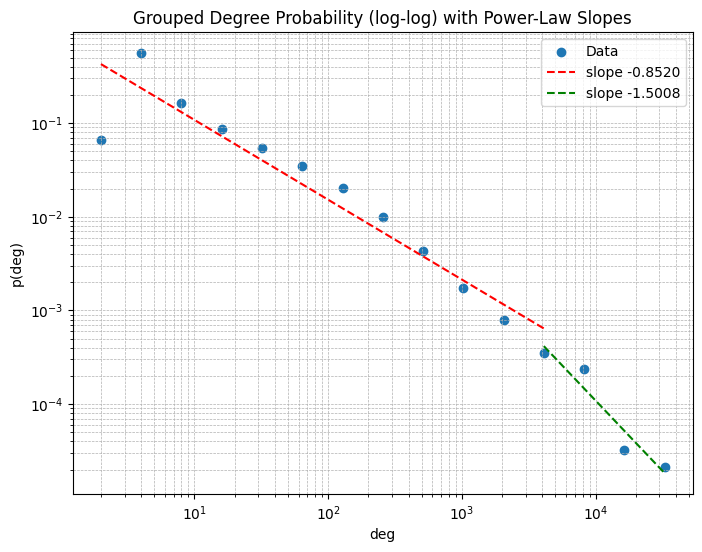

Anzahl der Knotengrade: 1029, max degree: 53890, Anzahl Buckets: 16
{1: np.float64(1.0768667485085395e-05), 2: np.float64(0.06605500635351381), 4: np.float64(0.55738622902802), 8: np.float64(0.1630914690616183), 16: np.float64(0.08669854192242252), 32: np.float64(0.05432792746225583), 64: np.float64(0.034728952639400415), 128: np.float64(0.0202020202020202), 256: np.float64(0.010014860761129386), 512: np.float64(0.0043182356615192345), 1024: np.float64(0.0017229867976136651), 2048: np.float64(0.00079688139389632), 4096: np.float64(0.0003553660270078183), 8192: np.float64(0.00023691068467187882), 16384: np.float64(3.2306002455256185e-05), 32768: np.float64(2.153733497017079e-05)}


In [47]:
grouped_dict = group_by_power_of_two(get_deg_probability_dict(G))
#print(grouped_dict)
grouped_dict.pop(1)
grouped_deg_prob_scatter_plot_with_slopes(grouped_dict, 4096)
asdf = group_by_power_of_two(get_deg_probability_dict(G))
print(asdf)

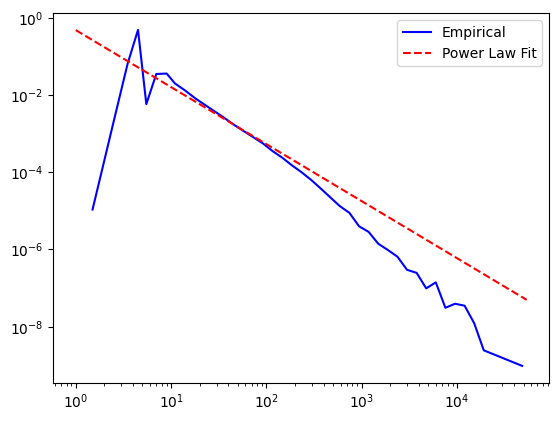

In [35]:
deg_list = [d for n, d in G.degree()]
fit = powerlaw.Fit(deg_list, xmin=1)

fit.plot_pdf(label="Empirical", color="blue")
fit.power_law.plot_pdf(label="Power Law Fit", color="red", linestyle="--")
plt.legend()
plt.show()

## Gruppierung und mögliche Trennungen, Link Distance 2

In [49]:
with open("../data/input/ALL_ALLmitMann_de.txt") as f:
    text = " ".join(f.readlines())
tokens = file_preprocesser.prepare_text_with_libraries(text, remove_stopwords=False, language="de")
G = file_preprocesser.convert_preprocessed_tokens_to_graph(tokens, neighbour_distance=2)

92862
1535363
Anzahl der Knotengrade: 1029, max degree: 53890, Anzahl Buckets: 16
{1: np.float64(1.0768667485085395e-05), 2: np.float64(0.06605500635351381), 4: np.float64(0.55738622902802), 8: np.float64(0.1630914690616183), 16: np.float64(0.08669854192242252), 32: np.float64(0.05432792746225583), 64: np.float64(0.034728952639400415), 128: np.float64(0.0202020202020202), 256: np.float64(0.010014860761129386), 512: np.float64(0.0043182356615192345), 1024: np.float64(0.0017229867976136651), 2048: np.float64(0.00079688139389632), 4096: np.float64(0.0003553660270078183), 8192: np.float64(0.00023691068467187882), 16384: np.float64(3.2306002455256185e-05), 32768: np.float64(2.153733497017079e-05)}
Anzahl der Knotengrade: 1029, max degree: 53890, Anzahl Buckets: 16


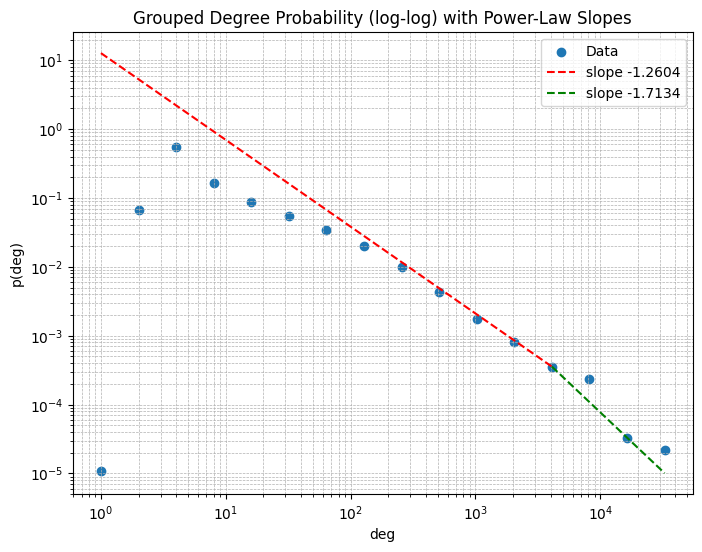

In [53]:
print(G.order())
print(len(G.edges()))
deg_prob_dict = get_deg_probability_dict(G)
print(group_by_power_of_two(deg_prob_dict))
grouped_deg_prob_scatter_plot_with_slopes2(group_by_power_of_two(deg_prob_dict))

In [51]:
regiment_candidates = find_word_regiment_candidates_grouped(deg_prob_dict, max_diff=10, start=1, group_method="lower")
print(regiment_candidates)
for split_at, vals in regiment_candidates.items():
    print(str.format("Trennung bei Bucket Nr.: {0} mit Wert {1} -> links: {2:.4f} / rechts: {3:.4f}", 
                     split_at, 2**split_at, vals["left"], vals["right"]))

Anzahl der Knotengrade: 1029, max degree: 53890, Anzahl Buckets: 16
{14: {'left': np.float64(1.182171485530273), 'right': np.float64(5.932606924752863)}, 4: {'left': np.float64(2.2089913149870943), 'right': np.float64(1.2165860979851355)}, 5: {'left': np.float64(2.2223920158129555), 'right': np.float64(1.2335217811793422)}, 13: {'left': np.float64(1.2551567477135777), 'right': np.float64(2.070144252744942)}, 3: {'left': np.float64(1.9879490100651767), 'right': np.float64(1.2020594625976528)}, 2: {'left': np.float64(1.9377473669857113), 'right': np.float64(1.187922685750368)}, 6: {'left': np.float64(1.948217169704947), 'right': np.float64(1.2546355902535498)}, 12: {'left': np.float64(1.2603969299528197), 'right': np.float64(1.7134295018299612)}, 7: {'left': np.float64(1.7308101545462196), 'right': np.float64(1.2822531726673976)}, 11: {'left': np.float64(1.2956960649699627), 'right': np.float64(1.542438272597443)}, 8: {'left': np.float64(1.5520897061417345), 'right': np.float64(1.3194567

/home/sebastian/Programming/Python/venvs/komplNetzeVenv/lib/python3.12/site-packages/powerlaw.py:1151: RuntimeWarning: divide by zero encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data/self.xmin)))
Not enough data. Returning nan


In [ ]:
regiment_candidates = find_word_regiment_candidates_grouped(deg_prob_dict, max_diff=10, start=1, group_method="upper")
for split_at, vals in regiment_candidates.items():
    print(str.format("Trennung bei Bucket Nr.: {0} mit Wert {1} -> links: {2:.4f} / rechts: {3:.4f}", 
                     split_at, 2**split_at, vals["left"], vals["right"]))

Anzahl der Knotengrade: 1029, max degree: 53890, Anzahl Buckets: 17
Trennung bei Bucket Nr.: 15 mit Wert 32768 -> links: 1.1848 / rechts: 5.9326
Trennung bei Bucket Nr.: 14 mit Wert 16384 -> links: 1.2628 / rechts: 2.0701
Trennung bei Bucket Nr.: 13 mit Wert 8192 -> links: 1.2708 / rechts: 1.7134
Trennung bei Bucket Nr.: 12 mit Wert 4096 -> links: 1.3132 / rechts: 1.5424
Trennung bei Bucket Nr.: 2 mit Wert 4 -> links: 1.3583 / rechts: 1.1814
Trennung bei Bucket Nr.: 3 mit Wert 8 -> links: 1.3069 / rechts: 1.1930
Trennung bei Bucket Nr.: 4 mit Wert 16 -> links: 1.2905 / rechts: 1.2038
Trennung bei Bucket Nr.: 11 mit Wert 2048 -> links: 1.3687 / rechts: 1.4412
Trennung bei Bucket Nr.: 5 mit Wert 32 -> links: 1.2868 / rechts: 1.2172
Trennung bei Bucket Nr.: 6 mit Wert 64 -> links: 1.2903 / rechts: 1.2339
Trennung bei Bucket Nr.: 7 mit Wert 128 -> links: 1.2982 / rechts: 1.2549
Trennung bei Bucket Nr.: 8 mit Wert 256 -> links: 1.3107 / rechts: 1.2825
Trennung bei Bucket Nr.: 10 mit Wert 10

Not enough data. Returning nan


Anzahl der Knotengrade: 1029, max degree: 53890, Anzahl Buckets: 16


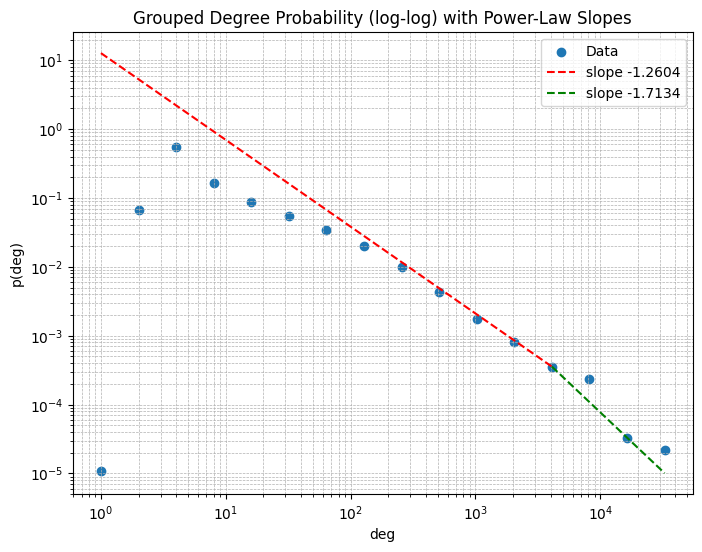

In [ ]:
#Beispielplot für dist = 2 und Trennpunkt: 4096. Aber die linke Linie ist Mist.
grouped_deg_prob_scatter_plot_with_slopes(group_by_power_of_two(get_deg_probability_dict(G), group_method="lower"))

Anzahl der Knotengrade: 1029, max degree: 53890, Anzahl Buckets: 16


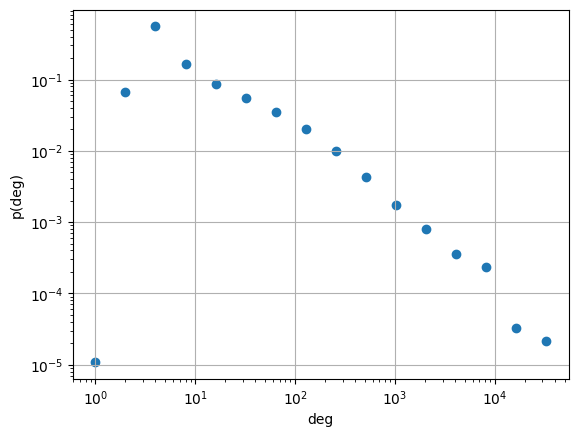

In [26]:
grouped_deg_prob_scatter_plot(group_by_power_of_two(get_deg_probability_dict(G), group_method="lower"))

Anzahl der Knotengrade: 1029, max degree: 53890, Anzahl Buckets: 17


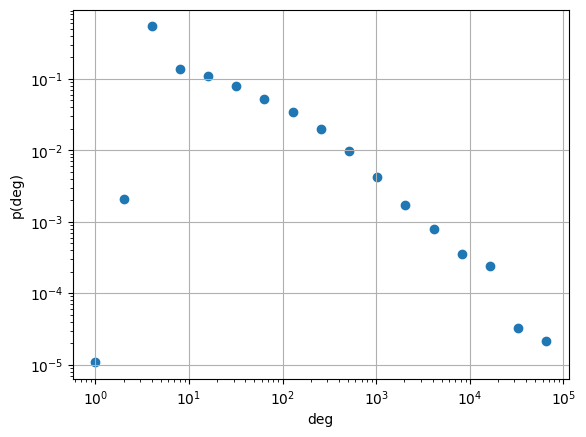

In [58]:
grouped_deg_prob_scatter_plot(group_by_power_of_two(get_deg_probability_dict(G), group_method="upper"))

In [21]:
deg_prob_dict = get_deg_probability_dict(G)
lastBucket = [k for k in deg_prob_dict.keys() if k > 32768]
print(lastBucket)

[40226]


In [55]:
deg_prob_dict = get_deg_probability_dict(G)
grouped = group_by_power_of_two(deg_prob_dict, group_method="lower")
node_count_per_bucket = get_node_count_per_bucket(G, grouped, group_method="lower")
for k, v in node_count_per_bucket.items():
    print(str.format("bucket: {0}, count: {1}", k, v))

Anzahl der Knotengrade: 1029, max degree: 53890, Anzahl Buckets: 16
[  0   1 191 ...   0   0   1]
bucket: 1, count: 1
bucket: 2, count: 6134
bucket: 4, count: 51760
bucket: 8, count: 15145
bucket: 16, count: 8051
bucket: 32, count: 5045
bucket: 64, count: 3225
bucket: 128, count: 1876
bucket: 256, count: 930
bucket: 512, count: 401
bucket: 1024, count: 160
bucket: 2048, count: 74
bucket: 4096, count: 33
bucket: 8192, count: 22
bucket: 16384, count: 3
bucket: 32768, count: 2


In [56]:
deg_prob_dict = get_deg_probability_dict(G)
grouped = group_by_power_of_two(deg_prob_dict, group_method="upper")
node_count_per_bucket = get_node_count_per_bucket(G, grouped, group_method="upper")
for k, v in node_count_per_bucket.items():
    print(str.format("bucket: {0}, count: {1}", k, v))

Anzahl der Knotengrade: 1029, max degree: 53890, Anzahl Buckets: 17
[  0   1 191 ...   0   0   1]
bucket: 1, count: 1
bucket: 2, count: 191
bucket: 4, count: 50711
bucket: 8, count: 12637
bucket: 16, count: 10376
bucket: 32, count: 7456
bucket: 64, count: 4868
bucket: 128, count: 3153
bucket: 256, count: 1852
bucket: 512, count: 924
bucket: 1024, count: 399
bucket: 2048, count: 160
bucket: 4096, count: 74
bucket: 8192, count: 33
bucket: 16384, count: 22
bucket: 32768, count: 3
bucket: 65536, count: 2


In [ ]:
#sanity check
sum = 0
for v in node_count_per_bucket.values():
    sum += v

print(sum == G.order())

True


## Gruppierung und mögliche Trennungen, Link Distance 1

In [9]:
with open("../data/input/ALL_ALLmitMann_de.txt") as f:
    text = " ".join(f.readlines())
tokens = file_preprocesser.prepare_text_with_libraries(text, remove_stopwords=False, language="de")
G = file_preprocesser.convert_preprocessed_tokens_to_graph(tokens, neighbour_distance=1)

In [10]:
print(G.order())
print(len(G.edges()))
deg_prob_dict = get_deg_probability_dict(G)

92862
821584


In [11]:
regiment_candidates = find_word_regiment_candidates_grouped(deg_prob_dict, max_diff=10, start=0, group_method="lower")
for split_at, vals in regiment_candidates.items():
    print(str.format("Trennung bei Bucket Nr.: {0} mit Wert {1} -> links: {2:.4f} / rechts: {3:.4f}", 
                     split_at, 2**split_at, vals["left"], vals["right"]))

Anzahl der Knotengrade: 712, max degree: 40226, Anzahl Buckets: 16
Trennung bei Bucket Nr.: 14 mit Wert 16384 -> links: 1.1949 / rechts: 2.8205
Trennung bei Bucket Nr.: 13 mit Wert 8192 -> links: 1.2082 / rechts: 2.0379
Trennung bei Bucket Nr.: 6 mit Wert 64 -> links: 1.8162 / rechts: 1.2533
Trennung bei Bucket Nr.: 5 mit Wert 32 -> links: 1.7384 / rechts: 1.2312
Trennung bei Bucket Nr.: 1 mit Wert 2 -> links: 1.6163 / rechts: 1.1748
Trennung bei Bucket Nr.: 4 mit Wert 16 -> links: 1.6519 / rechts: 1.2139
Trennung bei Bucket Nr.: 12 mit Wert 4096 -> links: 1.2520 / rechts: 1.6796
Trennung bei Bucket Nr.: 3 mit Wert 8 -> links: 1.5907 / rechts: 1.1995
Trennung bei Bucket Nr.: 2 mit Wert 4 -> links: 1.5610 / rechts: 1.1869
Trennung bei Bucket Nr.: 7 mit Wert 128 -> links: 1.6018 / rechts: 1.2819
Trennung bei Bucket Nr.: 11 mit Wert 2048 -> links: 1.2829 / rechts: 1.5183
Trennung bei Bucket Nr.: 10 mit Wert 1024 -> links: 1.2956 / rechts: 1.4322
Trennung bei Bucket Nr.: 8 mit Wert 256 -> 

Not enough data. Returning nan


In [12]:
regiment_candidates = find_word_regiment_candidates_grouped(deg_prob_dict, max_diff=10, start=0, group_method="upper")
for split_at, vals in regiment_candidates.items():
    print(str.format("Trennung bei Bucket Nr.: {0} mit Wert {1} -> links: {2:.4f} / rechts: {3:.4f}", 
                     split_at, 2**split_at, vals["left"], vals["right"]))

Anzahl der Knotengrade: 712, max degree: 40226, Anzahl Buckets: 17
Trennung bei Bucket Nr.: 15 mit Wert 32768 -> links: 1.1897 / rechts: 2.8205
Trennung bei Bucket Nr.: 14 mit Wert 16384 -> links: 1.2029 / rechts: 2.0379
Trennung bei Bucket Nr.: 7 mit Wert 128 -> links: 1.8287 / rechts: 1.2536
Trennung bei Bucket Nr.: 6 mit Wert 64 -> links: 1.7759 / rechts: 1.2317
Trennung bei Bucket Nr.: 5 mit Wert 32 -> links: 1.6966 / rechts: 1.2145
Trennung bei Bucket Nr.: 1 mit Wert 2 -> links: 1.6303 / rechts: 1.1697
Trennung bei Bucket Nr.: 4 mit Wert 16 -> links: 1.6422 / rechts: 1.2006
Trennung bei Bucket Nr.: 13 mit Wert 8192 -> links: 1.2453 / rechts: 1.6796
Trennung bei Bucket Nr.: 3 mit Wert 8 -> links: 1.6093 / rechts: 1.1892
Trennung bei Bucket Nr.: 2 mit Wert 4 -> links: 1.5994 / rechts: 1.1797
Trennung bei Bucket Nr.: 8 mit Wert 256 -> links: 1.5991 / rechts: 1.2823
Trennung bei Bucket Nr.: 12 mit Wert 4096 -> links: 1.2758 / rechts: 1.5183
Trennung bei Bucket Nr.: 11 mit Wert 2048 ->

Not enough data. Returning nan


Anzahl der Knotengrade: 712, max degree: 40226, Anzahl Buckets: 16


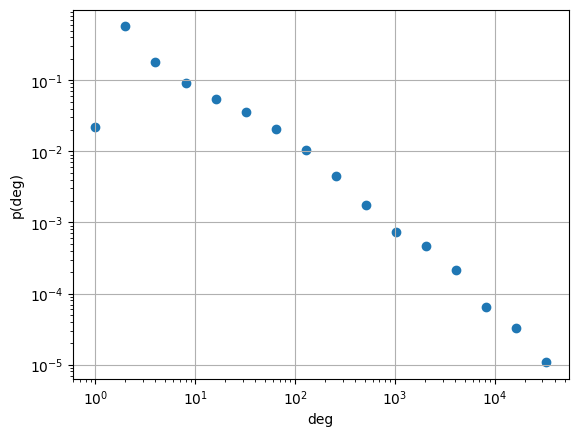

In [13]:
grouped_deg_prob_scatter_plot(group_by_power_of_two(get_deg_probability_dict(G), group_method="lower"))

Anzahl der Knotengrade: 712, max degree: 40226, Anzahl Buckets: 17


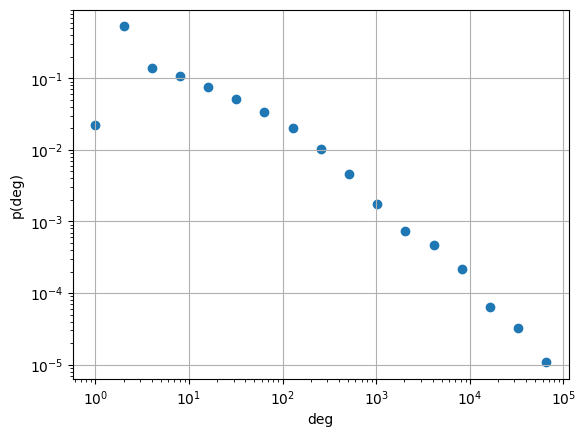

In [14]:
grouped_deg_prob_scatter_plot(group_by_power_of_two(get_deg_probability_dict(G), group_method="upper"))

In [15]:
deg_prob_dict = get_deg_probability_dict(G)
grouped = group_by_power_of_two(deg_prob_dict, group_method="lower")
node_count_per_bucket = get_node_count_per_bucket(G, grouped, group_method="lower")
for k, v in node_count_per_bucket.items():
    print(str.format("bucket: {0}, count: {1}", k, v))

Anzahl der Knotengrade: 712, max degree: 40226, Anzahl Buckets: 16
[    0  2073 49498 ...     0     0     1]
bucket: 1, count: 2073
bucket: 2, count: 53218
bucket: 4, count: 16973
bucket: 8, count: 8604
bucket: 16, count: 5091
bucket: 32, count: 3269
bucket: 64, count: 1923
bucket: 128, count: 980
bucket: 256, count: 424
bucket: 512, count: 165
bucket: 1024, count: 69
bucket: 2048, count: 43
bucket: 4096, count: 20
bucket: 8192, count: 6
bucket: 16384, count: 3
bucket: 32768, count: 1


In [16]:
deg_prob_dict = get_deg_probability_dict(G)
grouped = group_by_power_of_two(deg_prob_dict, group_method="upper")
node_count_per_bucket = get_node_count_per_bucket(G, grouped, group_method="upper")
for k, v in node_count_per_bucket.items():
    print(str.format("bucket: {0}, count: {1}", k, v))

Anzahl der Knotengrade: 712, max degree: 40226, Anzahl Buckets: 17
[    0  2073 49498 ...     0     0     1]
bucket: 1, count: 2073
bucket: 2, count: 49498
bucket: 4, count: 12951
bucket: 8, count: 9865
bucket: 16, count: 7029
bucket: 32, count: 4740
bucket: 64, count: 3118
bucket: 128, count: 1894
bucket: 256, count: 968
bucket: 512, count: 421
bucket: 1024, count: 164
bucket: 2048, count: 68
bucket: 4096, count: 43
bucket: 8192, count: 20
bucket: 16384, count: 6
bucket: 32768, count: 3
bucket: 65536, count: 1


# Versuch 2
Diesmal hoffentlich etwas strukturierter und mit ner Minute nachdenken.
### Formalitäten
- Powerlaw $\ne$ Exponential-Law, zu deutsch Potenzgesetz vs. Exponentialgesetz
- Potenzfunktion: $y=a\cdot x^b$ Für uns interessant ist Exponent $b$.
- Exponentialfunktion: $y = a^x$ oder auch $y=e^x$ für nat. Exponentialfunktion. 

### Powerlaw.Fit / Scipy.Fit
- arbeitet mit Rohdaten (hier: Liste der Knotengrade)
    - bzw. sollte mit Rohdaten arbeiten
- nimmt an, dass diese Rohdaten zu einer Potenzfunktion gehören und probiert beste Parameter zu finden.
- Parameter die hier rauskommen können in Visualisierung deutlicher von den Datenpunkten abweichen als lineare Regression.
- berüchsichtigt, dass ein überwältigender Teil der Werte "vorne" in Verteilung liegt und regiert damit nicht so stark auf *Ausreißer* am Ende (Tail) der Daten.
- versucht ebenfalls einen 

### Lineare Regression
- kann sowohl Rohdaten als auch gruppierte Daten verarbeiten.
- stumpfe, grafische Methode die *beste* Gerade durch Menge von Datenpunkten zieht. (geringster Gesamtabstand zu allen Punkten)
- nicht die präziseste Methode, aber *anschaulich* und oft verwendet.
- Ansatz: Logarithmus der Potenzfunktion bilden: $ln(y)=ln(a) + b \cdot ln(y)$.
    - da $x$ und $y$ Werte bekannt sind (unsere Daten) liegt auch $ln(x)$ und $ln(y)$ vor.
    - $b$ -> Steigung wird via geringstem Abstand zu allen Datenpunkten berechnet.
    - $ln(a)$ -> Schnittpunkt $y$->Achse, ergibt sich aus Steigung/Lage der Geraden für geringsten Abstand.

### Links:
https://www.physics.drexel.edu/~valliere/PHYS160/Textbook/Chapter_6/6.6.4.html
- Basic Erkärung Power-law, Exponential-law, Log-Log Fitting
https://arxiv.org/vc/cond-mat/papers/0402/0402322v1.pdf
- Erkärung & Beurteilung von u.a. MLE (Maximum likelihood estimation) und linearer Regression zum fitten von Power-Law Distributions.

### Was heißt das nun für uns?!
- Um den Plot aus *a small world of human language* nachzustellen sollte Gruppierung & lineare Regression korrekt sein.
- diese Steigung(en) aus der linearen Regression können wir dann auch als (geschätzen) Exponenten angeben. 
    - paper sagt ebenfalls nur $\gamma \approx 1.50$ etc.
    - mit Angabe der Methoden zur Gruppierung und Bestimmung der Exponenten sehe ich hier kein Problem "mehr".
        - bei der Gruppierung erwähnen, dass die Wahrscheinlichkeiten je Bucket aufsummiert wurden. \
        Soll auch Binning mit average drin geben.
- **Problem in Plot:** Beim Einzeichnen der beiden Graden für die beiden unterschiedlichen Exponenten "treffen" diese sich \ 
schön an einem Punkt und auf diesem Punkt. Ich weiß gerade nicht mit welcher Magie die das machen.
- für den zweiten Part könnten wir überlegen lineare Regression nur für die ersten 5 Punkte (deg 1-5) zu betreiben als zusätzliche Metrik. 
    - Siehe verlinktes Paper, wird dort Alternativ zum Gruppieren vorgeschlagen da es *noise* am Ende ignoriert
- generell würde ich sagen die Verwendung beider Methoden ist ok solange angemerkt wobei lineare Regression erforderlich ist um Plot nachzubilden.
    - rein aus Prinzip könen wir im ersten Part auch das powerlaw.Fit Ergebnis mit angeben falls es und besser in die Karten passt da wir \
    die Diskrepanz nun etwas erklären können. (mit 1-2 Papers dazu im Rücken wäre es natürlich noch besser)

### Also: Kurzfristige ToDos im Kontext Part 1 / ALL_ALLmitMann Netz:
- [X] saubere Gruppierungsfunktion
- [X] saubere lineare Regressions Funktion
- [X] saubere analysiere-Trennpunkte Funktion
- [X] $deg = 1$ sollte als Ausreißer ignoriert werden. Entweder nach Gruppierung oder vor/während lin reg
- [X] saubere Plot Funktion für eine Gerade.
- [ ] Powerlaw.Fit Vergleichswerte berechnen und irgendwo notieren.
- [X] Lineare Regression und Plot für gruppierte Werte als ein ganzes "Regiment" als *sanity check*
- [ ] Falls uns Werte nicht in den Kram passen (aka keine Scale-Free Eigenschaft sichtbar): mögliche Erklärung suchen.
- [X] Plot Funktion inkl. der beiden Geraden.
    - Falls Gerade sich nicht "treffen" am Trennpunkt kurz recherchieren ob/wie man Gerade dort "verankern" könnte. \ 
    Ansonsten würde ich es fast schon dabei belassen.
    - [ ] Kurze Prüfung ob wie sich Gearde am Trennpunkt "verankern" lassen bzw. warum Sie im paper so schön sind.
- [ ] TATSÄCHLICH MAL NEN WORT IN DIE SEMINARARBEIT SCHREIBEN DU ESEL!!


In [43]:
#Funktionen 
def group_by_power_of_two(deg_prob_dict, group_method="lower"):
    max_deg = max(deg_prob_dict.keys())
    bucket_dict = dict()
    for deg, prob in deg_prob_dict.items():
        if group_method == "lower":
            bucket = 2 ** int(np.floor(np.log2(deg)))
        elif group_method == "upper":
            bucket = 2 ** int(np.ceil(np.log2(deg)))
        #print(str.format("deg: {0}, bin: {1}", deg, bucket))
        if bucket not in bucket_dict:
            bucket_dict[bucket] = prob
        else:
            bucket_dict[bucket] = bucket_dict[bucket] + prob
    print(str.format("Anzahl der Knotengrade: {0}, max degree: {1}, Anzahl Buckets: {2}", len(deg_prob_dict), max_deg, len(bucket_dict)))
    return bucket_dict
	
def get_deg_probability_dict(graph):
    deg_frequency_list = np.array(nx.degree_histogram(graph))
    total_nodes = graph.order()
    res = {}
    for deg in range(len(deg_frequency_list)):
        if deg_frequency_list[deg] == 0: continue
        else:
            res[deg] = deg_frequency_list[deg] / total_nodes
    return res

def lin_reg_on_grouped_deg_prob_dict(grouped_dict):
    sorted_dict = dict(sorted(grouped_dict.items()))
    x_values = list(sorted_dict.keys())
    y_values = list(sorted_dict.values())
    return lin_reg_on_deg_prob_lists(x_values, y_values)

def lin_reg_on_deg_prob_lists(x_values, y_values):
    #print("x_values: ", x_values)
    #print("y_values: ", y_values)
    #convert to log scale
    x_values = np.log10(x_values)
    y_values = np.log10(y_values)
    lin_reg_results = linregress(x_values, y_values)
    # results contain: slope, intercept (y-axis cutting point), rvalue, pvalue, stderr
    return lin_reg_results

def find_regiment_candidates_linreg(deg_prob_dict, start=0, stop=0, step=1, max_diff=5, group_method="lower"):
    """
    Outliers must be removed in advance! 
    start param only controls where we begin checking for regiments. It will still include the values < start!!
    """
    bucket_dict = group_by_power_of_two(deg_prob_dict, group_method=group_method)
    #print("bucket dict: ", bucket_dict)
    sorted_tuple_list = [(bucket, bucket_dict[bucket]) for bucket in sorted(bucket_dict.keys())]
    #print("sorted tuple list: ", sorted_tuple_list)
    res = dict()

    for i in range(start, stop if stop != 0 else len(sorted_tuple_list)-1, step): #we will check at least two data points in tail.
        left = sorted_tuple_list[:i+1] #cutting point will be included in both
        right = sorted_tuple_list[i:]
        bins_left = [t[0] for t in left]
        probs_left = [t[1] for t in left]
        bins_right = [t[0] for t in right]
        probs_right = [t[1] for t in right]
        #print("bins_left: ", bins_left)
        #print("probs_left: ", probs_left)
        #print("bins_right: ", bins_right)
        #print("probs_right: ", probs_right)

        results_left = lin_reg_on_deg_prob_lists(bins_left, probs_left)
        results_right = lin_reg_on_deg_prob_lists(bins_right, probs_right)
        res[i] = { "slope_left": results_left.slope, 
                  "intercept_left": results_left.intercept,
                  "slope_right": results_right.slope,
                  "intercept_right": results_right.intercept
                  }

    #sort by difference between left-right regiment, desc
    res = dict(filter(lambda item: abs(item[1]["slope_left"] - item[1]["slope_right"]) <= max_diff, res.items()))
    res = dict(sorted(
        res.items(), 
        key=lambda item: abs(item[1]["slope_left"] - item[1]["slope_right"]),
        reverse=True
        ))
    return res

def print_regiment_candidates(regiment_candidate_dict):
    for split_at, vals in regiment_candidate_dict.items():
        print(str.format("Cut bei Bucket {0} mit Trennwert {1} -> Links slope / intercept: {2:.3f} / {3:.1f} | Rechts slope / intercept: {4:.3f} / {5:.1f}", 
                        split_at, 2**split_at, 
                        vals["slope_left"], vals["intercept_left"],
                        vals["slope_right"], vals["intercept_right"]))


def plot_grouped_single_regiment(grouped_dict, slope, intercept):
    x = np.array(list(grouped_dict.keys()), dtype=int)
    y = np.array(list(grouped_dict.values()), dtype=float)
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, label="grouped")

    x_values_line = np.logspace(np.log10(min(x)), np.log10(max(x)), 100)
    y_values_line = 10 ** (slope * np.log10(x_values_line) + intercept)
    plt.plot(x_values_line, y_values_line, color="red", label=str.format("{0:.4f}", slope))

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("deg")
    plt.ylabel("p(deg)")
    plt.grid(True, which="major", ls="--", lw=0.5)
    plt.legend()
    plt.title("Grouped Degree Probability (log-log) with Power-Law Slopes")
    plt.show()
    return

def plot_grouped_two_regiments(grouped_dict, split_at, slope_first_regiment, intercept_first_regiment, slope_second_regiment, intercept_second_regiment):
    x = np.array(list(grouped_dict.keys()), dtype=int)
    y = np.array(list(grouped_dict.values()), dtype=float)
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, label="grouped")

    x_values_first_regiment = np.logspace(np.log10(min(x)), np.log10(split_at), 100)
    y_values_first_regiment = 10 ** (slope_first_regiment * np.log10(x_values_first_regiment) + intercept_first_regiment)
    plt.plot(x_values_first_regiment, y_values_first_regiment, color="red", label=str.format("{0:.4f}", slope_first_regiment))

    x_values_second_regiment = np.logspace(np.log10(split_at), np.log10(max(x)), 100)
    y_values_second_regiment = 10 ** (slope_second_regiment * np.log10(x_values_second_regiment) + intercept_second_regiment)
    plt.plot(x_values_second_regiment, y_values_second_regiment, color="green", label=str.format("{0:.4f}", slope_second_regiment))

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("deg")
    plt.ylabel("p(deg)")
    plt.grid(True, which="major", ls="--", lw=0.5)
    plt.legend()
    plt.title("Grouped Degree Probability (log-log) with Power-Law Slopes")
    plt.show()
    return


### Versuch 2 - Analyse, nu aber

In [ ]:
with open("../data/input/ALL_ALLmitMann_de.txt") as f:
#with open("../data/input/Kafka_Verwandlung_de.txt") as f:
    text = " ".join(f.readlines())
tokens = file_preprocesser.prepare_text_with_libraries(text, remove_stopwords=False, language="de")
G = file_preprocesser.convert_preprocessed_tokens_to_graph(tokens, neighbour_distance=2)

#### Analyse eine Gerade

In [31]:
deg_prob_dict = get_deg_probability_dict(G)
deg_prob_dict.pop(1) #remove 1 as its an outlier
#print(deg_prob_dict)
grouped_dict = group_by_power_of_two(deg_prob_dict, group_method="lower")
#print(grouped_dict)
lin_reg_results = lin_reg_on_grouped_deg_prob_dict(grouped_dict)
print("slope: ", lin_reg_results.slope)
print("intercept: ", lin_reg_results.intercept)

Anzahl der Knotengrade: 1028, max degree: 53890, Anzahl Buckets: 15
x_values:  [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
y_values:  [np.float64(0.06605500635351381), np.float64(0.55738622902802), np.float64(0.1630914690616183), np.float64(0.08669854192242252), np.float64(0.05432792746225583), np.float64(0.034728952639400415), np.float64(0.0202020202020202), np.float64(0.010014860761129386), np.float64(0.0043182356615192345), np.float64(0.0017229867976136651), np.float64(0.00079688139389632), np.float64(0.0003553660270078183), np.float64(0.00023691068467187882), np.float64(3.2306002455256185e-05), np.float64(2.153733497017079e-05)]
slope:  -0.9769625299983109
intercept:  0.07535869383418259


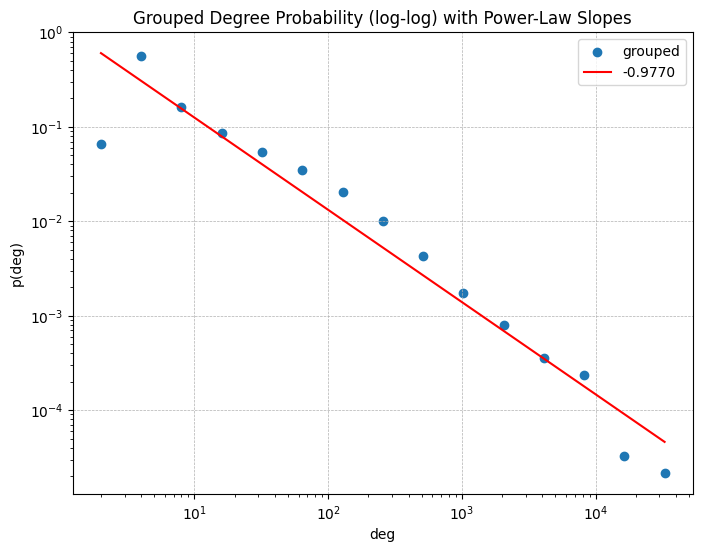

In [ ]:
plot_grouped_single_regiment(grouped_dict, lin_reg_results.slope, lin_reg_results.intercept)

#### Analyse zwei Geraden

In [40]:
deg_prob_dict = get_deg_probability_dict(G)
deg_prob_dict.pop(1)
candidates = find_regiment_candidates_linreg(deg_prob_dict, start=4 ,group_method="lower", max_diff=10)
print_regiment_candidates(candidates)

Anzahl der Knotengrade: 1028, max degree: 53890, Anzahl Buckets: 15
Cut bei Bucket 12 mit Trennwert 4096 -> Links slope / intercept: -0.871 / -0.1 | Rechts slope / intercept: -1.730 / 3.0
Cut bei Bucket 4 mit Trennwert 16 -> Links slope / intercept: -0.325 / -0.6 | Rechts slope / intercept: -1.165 / 0.7
Cut bei Bucket 5 mit Trennwert 32 -> Links slope / intercept: -0.446 / -0.5 | Rechts slope / intercept: -1.211 / 0.9
Cut bei Bucket 6 mit Trennwert 64 -> Links slope / intercept: -0.526 / -0.5 | Rechts slope / intercept: -1.250 / 1.0
Cut bei Bucket 7 mit Trennwert 128 -> Links slope / intercept: -0.599 / -0.4 | Rechts slope / intercept: -1.275 / 1.1
Cut bei Bucket 11 mit Trennwert 2048 -> Links slope / intercept: -0.852 / -0.1 | Rechts slope / intercept: -1.501 / 2.0
Cut bei Bucket 8 mit Trennwert 256 -> Links slope / intercept: -0.675 / -0.3 | Rechts slope / intercept: -1.292 / 1.2
Cut bei Bucket 10 mit Trennwert 1024 -> Links slope / intercept: -0.805 / -0.2 | Rechts slope / intercept

Anzahl der Knotengrade: 1028, max degree: 53890, Anzahl Buckets: 15


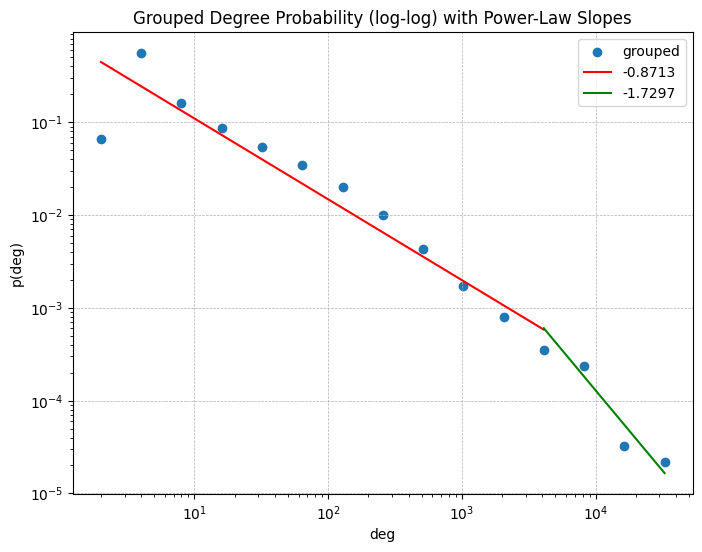

In [42]:
grouped_dict = group_by_power_of_two(deg_prob_dict, group_method="lower")
regiment_values = candidates[12]
plot_grouped_two_regiments(grouped_dict, 4096, 
                           regiment_values["slope_left"], regiment_values["intercept_left"], 
                           regiment_values["slope_right"], regiment_values["intercept_right"])